In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import sys

from scipy.ndimage.filters import uniform_filter1d

sys.path.append('/home/lugeon/eeg_project/scripts')

sns.set_context("paper")
sns.set(font_scale = 1.6)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

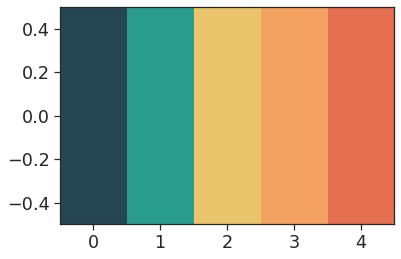

In [2]:
from matplotlib import colors
palette = ['#264653', '#2A9D8F','#E9C46A', '#F4A261', '#E76F51']
cmap = colors.ListedColormap(palette)

plt.imshow(np.arange(len(palette)).reshape(1, -1), aspect='auto', cmap=cmap,origin="lower")
plt.show()

## Basic statistics

In [24]:
hdf5_file = '/mlodata1/lugeon/dream_data/processed/healthy/dataset.h5'

with h5py.File(hdf5_file, 'r') as f:
    subjects = [s.decode('utf-8') for s in f['subject_name'][:]]
    subject_id = f['subject_id'][:]
    trial_id = f['trial_id'][:]
    sleep_stage = f['sleep_stage'][:]
    labels = f['labels'][:]
    
subjects

['H009',
 'H018',
 'H019',
 'H021',
 'H025',
 'H026',
 'H033',
 'H035',
 'H048',
 'H050',
 'H051',
 'H054',
 'H055',
 'H057',
 'H060',
 'H089',
 'H099',
 'H100',
 'H061',
 'H068']

In [25]:
df = pd.DataFrame({'sid': subject_id, 'tid': trial_id, 'ss': sleep_stage, 'label': labels})
df

,sid,tid,ss,label
0,0.0,0.0,3.0,1.0
1,0.0,0.0,3.0,1.0
2,0.0,0.0,3.0,1.0
3,0.0,0.0,3.0,1.0
4,0.0,0.0,3.0,1.0
...,...,...,...,...
123472,19.0,30.0,4.0,1.0
123473,19.0,30.0,4.0,1.0
123474,19.0,30.0,4.0,1.0
123475,19.0,30.0,4.0,1.0


In [26]:
trial_count = df.drop_duplicates(['sid', 'tid']).groupby(['sid', 'ss', 'label']).tid.count()
trial_count.sum()

521

In [27]:
trials = df.drop_duplicates(['sid', 'tid'])

In [28]:
trials

,sid,tid,ss,label
0,0.0,0.0,3.0,1.0
237,0.0,1.0,2.0,1.0
474,0.0,2.0,2.0,1.0
711,0.0,3.0,2.0,1.0
948,0.0,4.0,2.0,2.0
...,...,...,...,...
122292,19.0,26.0,2.0,1.0
122529,19.0,27.0,2.0,1.0
122766,19.0,28.0,2.0,2.0
123003,19.0,29.0,4.0,1.0


In [29]:
rem_ne = trials.groupby('sid').apply(lambda g: sum((g.ss == 4) & (g.label == 0)))
rem_de = trials.groupby('sid').apply(lambda g: sum((g.ss == 4) & (g.label == 2)))
rem_dewr = trials.groupby('sid').apply(lambda g: sum((g.ss == 4) & (g.label == 1)))

nrem_ne = trials.groupby('sid').apply(lambda g: sum((g.ss != 4) & (g.label == 0)))
nrem_de = trials.groupby('sid').apply(lambda g: sum((g.ss != 4) & (g.label == 2)))
nrem_dewr = trials.groupby('sid').apply(lambda g: sum((g.ss != 4) & (g.label == 1)))

tot_ne = rem_ne + nrem_ne
tot_de = rem_de + nrem_de
tot_dewr = rem_dewr + nrem_dewr

In [30]:
trials.shape[0]

521

In [31]:
rem_ne.sum() + rem_de.sum() + rem_dewr.sum() + nrem_ne.sum() + nrem_de.sum() + nrem_dewr.sum()

521

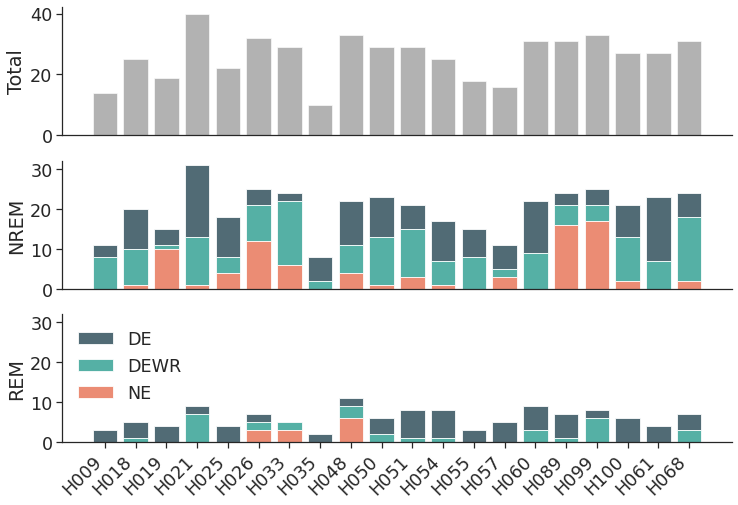

In [32]:
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

x = np.arange(len(subjects))

axs[0].bar(x, tot_ne + tot_de + tot_dewr, color='grey', alpha=0.6)

axs[1].bar(x, nrem_de, bottom=nrem_ne+nrem_dewr, color=cmap(0), alpha=0.8)
axs[1].bar(x, nrem_dewr, bottom=nrem_ne, color=cmap(1), alpha=0.8)
axs[1].bar(x, nrem_ne, color=cmap(4), alpha=0.8)

axs[2].bar(x, rem_de, label='DE', bottom=rem_ne+rem_dewr, color=cmap(0), alpha=0.8)
axs[2].bar(x, rem_dewr, label='DEWR', bottom=rem_ne, color=cmap(1), alpha=0.8)
axs[2].bar(x, rem_ne, label='NE', color=cmap(4), alpha=0.8)

axs[0].set_ylabel('Total')
axs[1].set_ylabel('NREM')
axs[2].set_ylabel('REM')

axs[1].set_ylim([0, 32])
axs[2].set_ylim([0, 32])

axs[1].set_yticks([0, 10, 20, 30])
axs[2].set_yticks([0, 10, 20, 30])

axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].set_xticks(x)
axs[2].set_xticklabels(subjects, rotation=45, ha='right')

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 

legend = axs[2].legend(frameon=False, loc='upper left')
plt.savefig('img/trial_per_subject.png', bbox_inches='tight')

plt.plot();

In [17]:
# trials percentage in NREM sleep
( nrem_ne.sum() + nrem_de.sum() + nrem_dewr.sum() ) / trials.shape[0]

0.7673076923076924

In [18]:
# trials percentage in REM sleep
( rem_ne.sum() + rem_de.sum() + rem_dewr.sum() ) / trials.shape[0]

0.2326923076923077

In [19]:
trials.label.value_counts() / trials.shape[0]

2.0    0.448077
1.0    0.369231
0.0    0.182692
Name: label, dtype: float64

In [20]:
trials.sid.value_counts()

3.0     40
8.0     33
16.0    33
5.0     32
19.0    31
15.0    31
14.0    31
9.0     29
10.0    29
6.0     29
17.0    27
18.0    27
1.0     25
11.0    25
4.0     21
2.0     19
12.0    18
13.0    16
0.0     14
7.0     10
Name: sid, dtype: int64

## Distribution per channel

### Before normalization 

In [25]:
dir_path = '/mlodata1/lugeon/dream_data/processed/healthy/freq'

subjects = []

for file in glob.glob(f'{dir_path}/*'):
    with np.load(file) as f:
        trials = []
        for trial in f:
            signal = f[trial]
            if signal.shape != (237, 256, 5):
                print(trial)
            else:
                trials.append(signal)
            
        subjects.append(np.stack(trials))

In [26]:
subjects[0].shape

IndexError: list index out of range

In [5]:
# means over trials and frames
means = [s.mean(axis=(0, 1)) for s in subjects]
means[0].shape

(256, 5)

In [218]:
snames = [s.split('/')[-1].split('.')[0] for s in glob.glob(f'{dir_path}/*')]
snames

['H009',
 'H018',
 'H019',
 'H021',
 'H025',
 'H026',
 'H033',
 'H035',
 'H048',
 'H050',
 'H051',
 'H054',
 'H055',
 'H057',
 'H060',
 'H089',
 'H099',
 'H100',
 'H061',
 'H068']

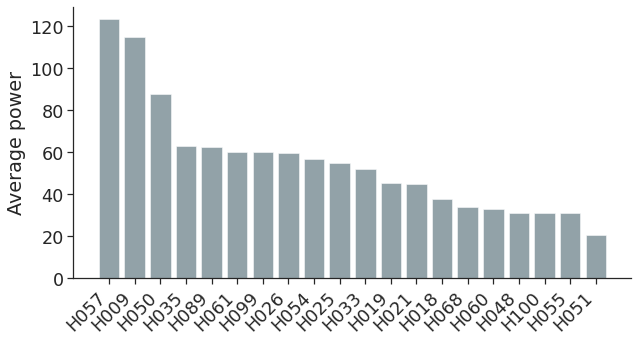

In [7]:
# average power over all electrode, per subject
low_freq_mean = [m[:, 0].mean() for m in means]

fig, ax = plt.subplots(figsize=(10, 5))

sort_ix = np.argsort(low_freq_mean)[::-1]
y = np.array(low_freq_mean)[sort_ix]
x = np.arange(len(low_freq_mean))

plt.bar(x, y, color=cmap(0), alpha=0.5)

ax.set_xticks(x)
ax.set_xticklabels(np.array(snames)[sort_ix], rotation=45, ha='right')

plt.ylabel('Average power')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.savefig('img/power_per_subject.pdf', bbox_inches='tight')

plt.show()

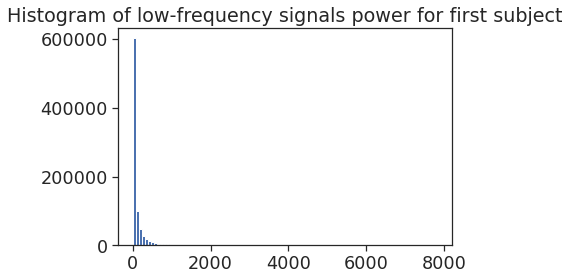

In [8]:
plt.hist(subjects[0][:, :, :, 0].flatten(), bins=100)
plt.title('Histogram of low-frequency signals power for first subject')
plt.show()

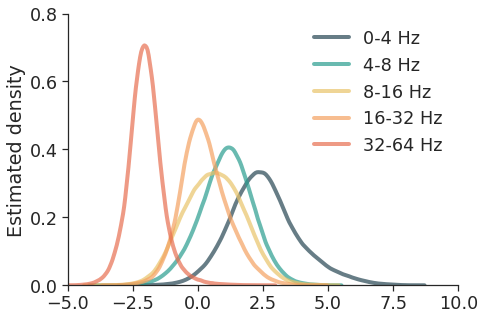

In [11]:
subject = 1
signal = subjects[subject]

bandwidths = ['0-4 Hz', '4-8 Hz', '8-16 Hz', '16-32 Hz', '32-64 Hz']

fig, ax = plt.subplots(figsize=(7, 5))

for bw in range(signal.shape[3]):
    f = np.log(signal[:, :, :, bw].flatten())

    sns.kdeplot(f, ax=ax, linewidth=4, color=cmap(bw), alpha=0.7, label=bandwidths[bw])
    
    
plt.legend(frameon=False)

plt.ylabel('Estimated density')

plt.ylim(0, 0.8)
plt.xlim(-5, 10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.savefig('img/frequency_density.pdf', bbox_inches='tight')

plt.show()

In [12]:
# Standard deviation over trials -- high variance across trials for a same subject!
for i, s in enumerate(subjects):
    mean = s[:, :, :, 0].mean(axis=(1, 2)).mean()
    std = s[:, :, :, 0].mean(axis=(1, 2)).std()
    sname = snames[i]
    print(f'{sname}: mean = {mean:<6.2f}, std = {std:<6.2f}')

H009: mean = 114.78, std = 106.54
H018: mean = 37.93 , std = 33.02 
H019: mean = 45.49 , std = 30.26 
H021: mean = 44.77 , std = 33.30 
H025: mean = 55.06 , std = 39.26 
H026: mean = 59.75 , std = 47.60 
H033: mean = 52.29 , std = 32.87 
H035: mean = 63.13 , std = 42.73 
H048: mean = 31.13 , std = 24.63 
H050: mean = 87.63 , std = 71.58 
H051: mean = 20.79 , std = 14.47 
H054: mean = 57.07 , std = 52.58 
H055: mean = 30.97 , std = 20.18 
H057: mean = 123.28, std = 104.57
H060: mean = 32.94 , std = 20.85 
H089: mean = 62.40 , std = 52.43 
H099: mean = 60.02 , std = 40.41 
H100: mean = 31.13 , std = 27.98 
H061: mean = 60.34 , std = 39.47 
H068: mean = 33.90 , std = 19.89 


### After normalization 

In [13]:
dir_path = '/mlodata1/lugeon/dream_data/processed/healthy/norm'

subjects = []

for file in glob.glob(f'{dir_path}/*'):
    with np.load(file) as f:
        trials = []
        for trial in f:
            signal = f[trial]
            if signal.shape != (237, 256, 5):
                print(trial)
            else:
                trials.append(signal)
            
        subjects.append(np.stack(trials))

AttributeError: 'int' object has no attribute 'shape'

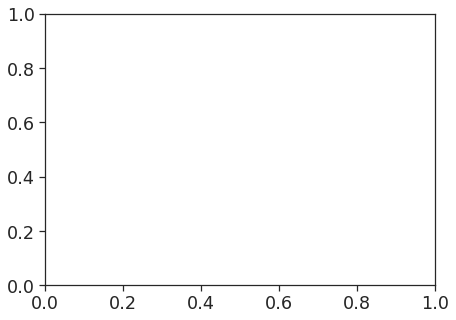

In [234]:
subject = 1
signal = subjects[subject]

bandwidths = ['0-4 Hz', '4-8 Hz', '8-13 Hz', '13-32 Hz', '32-100 Hz']

fig, ax = plt.subplots(figsize=(7, 5))

for bw in range(signal.shape[3]):
    f = signal[:, :, :, bw].flatten()

    sns.kdeplot(f, ax=ax, linewidth=4, color=cmap(bw), alpha=0.7, label=bandwidths[bw])
    
    
plt.legend(frameon=False)

plt.ylabel('Estimated density')

plt.ylim(0, 0.8)
plt.xlim(-5, 10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.savefig('img/frequency_density.pdf', bbox_inches='tight')

plt.show()

## Variation through the night

In [219]:
with h5py.File('/mlodata1/lugeon/dream_data/processed/baseline/dataset.h5') as f:
    df = pd.DataFrame({
                'sid': f['subject_id'][:], 
                'tid': f['trial_id'][:], 
                'fid': f['frame_id'][:],
                'ss': f['sleep_stage'][:],
                'sc': f['sleep_cycle'][:]
                })
    
    images = f['images'][:]
    
    snames = f['subject_name'][:]

In [59]:
images.shape

(601977, 5, 32, 32)

In [223]:
snames = [s.decode('utf-8') for s in snames]

AttributeError: 'str' object has no attribute 'decode'

In [224]:
snames

['H051',
 'H055',
 'H026',
 'H033',
 'H019',
 'H009',
 'H018',
 'H021',
 'H048',
 'H050',
 'H025',
 'H061',
 'H057',
 'H060']

In [77]:
indices = df.reset_index(inplace=False) \
    .groupby(['sid', 'sc']) \
    .apply(lambda g: g.sort_values('fid').index.tolist())
    
indices.head()

sid  sc 
0.0  1.0    [4734, 13842, 13843, 4735, 4736, 13844, 4737, ...
     2.0    [7431, 19779, 19780, 7432, 7433, 19781, 7434, ...
     3.0    [9408, 28056, 28057, 9409, 9410, 28058, 9411, ...
     4.0    [11385, 28473, 11386, 28474, 11387, 28475, 113...
     5.0    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
dtype: object

In [135]:
subject = 0
ix_subject = []
ix_subject.extend(indices[subject])
ix_subject = [i for ix in ix_subject for i in ix]

means = images[ix_subject].mean((2, 3))
means.shape

(34530, 5)

In [166]:
[list(images[ix].mean((0, 2, 3))) for ix in indices[0]]

[[0.18227324, 0.26280168, 0.06087519, 0.03252064, 0.28001165],
 [0.23205872, 0.12602004, 0.03639228, -0.0032771465, 0.042407397],
 [-0.73358625, -0.56065476, -0.39025196, -0.32725888, -0.42012307],
 [-0.1430576, -0.1422128, -0.003412544, -0.07684206, -0.107133634],
 [-0.46105143, -0.38623962, -0.15765475, 0.2463869, -0.18212414],
 [-0.18225996, -0.1962385, 0.030182317, 0.25197342, -0.19888939]]

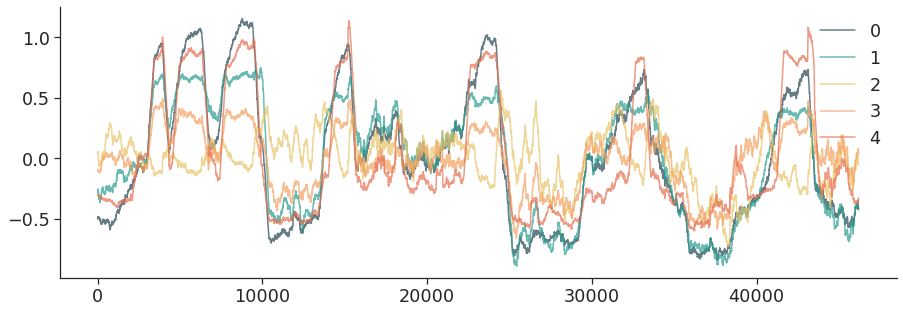

In [140]:
fig, ax = plt.subplots(figsize=(15, 5))

subject = 5
ix_subject = []
ix_subject.extend(indices[subject])
ix_subject = [i for ix in ix_subject for i in ix]

means = images[ix_subject].mean((2, 3))

for bw in range(means.shape[1]):
    
    signal = uniform_filter1d(means[:, bw], size=400)
    plt.plot(np.arange(signal.shape[0]), signal, c=cmap(bw), alpha=0.7, label=bw)
    
plt.legend(frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.savefig('img/frequency_density.pdf', bbox_inches='tight')

plt.show()

In [141]:
n_cycles = 4
n_channels = 5
n_subjects = 3
cycle_means = np.zeros((n_subjects, 5, 4))
for s in range(n_subjects):
    for c in range(n_cycles):
        cycle_means[s, :, c] = images[indices[s][c+1]].mean((0, 2, 3))

In [142]:
cycle_means.shape 

(3, 5, 4)

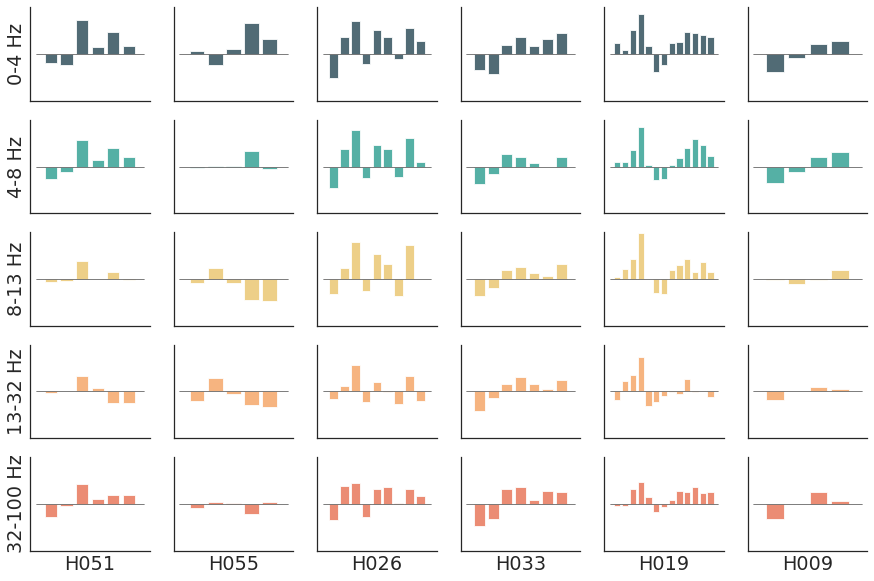

In [239]:
subjects_id = [0, 1, 2, 3, 4, 5]

fig, axs = plt.subplots(5, len(subjects_id), figsize=(15, 10))

h = 0
for sid in subjects_id:

    cycle_means = np.array([list(images[ix].mean((0, 2, 3))) for ix in indices[sid]])

    bar_width = 0.1
    n_cycles = cycle_means.shape[0]
    n_channels = cycle_means.shape[1]

    for bw in range(n_channels):
        
        axs[bw, h].bar(np.arange(n_cycles), cycle_means[:, bw], color=cmap(bw), alpha=0.8)
        axs[bw, h].plot([-1, n_cycles], [0, 0], linestyle='-', color='black', lw=0.5)
        
        axs[bw, h].spines['right'].set_visible(False)
        axs[bw, h].spines['top'].set_visible(False)
        
        axs[bw, h].set_ylim([1, -1])
        axs[bw, h].set_xticks([])
        axs[bw, h].set_yticks([])
            
        if bw == n_channels - 1:
            axs[bw, h].set_xlabel(f'{snames[sid]}')
            
        if h == 0:
            axs[bw, h].set_ylabel(f'{bandwidths[bw]}')
            
    h += 1
    
#plt.legend(frameon=False)


#plt.savefig('img/amplitude_per_cycle.pdf', bbox_inches='tight')

plt.show()